# 데이터 처리
## investing.com
### JOIN 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [ ]:
data_df = pd.read_excel('palm_nino_concat.xlsx')

In [ ]:
data_df.head()

### 데이터 선택
2008년 이전 데이터는 불연속적이므로 2008년 이후만 사용한다.

In [ ]:
df = data_df.query('YEAR > 2007')

In [ ]:
df

### 인덱스, 열 처리

In [ ]:
df.set_index('DATE', inplace = True)

In [ ]:
df.drop(columns = ['YEAR', 'MONTH', 'year', 'month'], inplace = True)

In [ ]:
df.head()

## FIS

### FIS 팜유-nino3.4 JOIN 데이터 만들기

In [16]:
palm_df = pd.read_excel('PALMOIL_FUTURE-FIS.xlsx')
nino34_df = pd.read_excel('nino34.xlsx', sheet_name = 'Nino3.4')

In [17]:
nino34_df = pd.melt(nino34_df, id_vars=['year'], value_vars=list(nino34_df.columns.values)[1:], var_name='month', value_name='nino34')

In [ ]:
nino34_df.head()

In [19]:
nino34_df['DATE'] = pd.to_datetime(nino34_df[['year', 'month']].assign(DAY=1))
nino34_df.sort_values(by='DATE', inplace=True)

In [ ]:
nino34_df.head()

In [21]:
palm_df.rename(columns = {'기간(월)': 'DATE'}, inplace = True)

In [ ]:
palm_df.head()

In [ ]:
print(len(nino34_df))
print(len(palm_df))

In [24]:
df = palm_df.merge(nino34_df, how = 'inner', on = 'DATE')

In [ ]:
len(df)

In [ ]:
df.sort_values(by = 'DATE', inplace = True)
df

### 인덱스, 열 처리

In [27]:
df.set_index('DATE', inplace = True)
df.drop(columns = ['전년동월평균가', '전년도동월대비', 'year', 'month', '평균가', '등락률(%)', '환산가($/ton)'], inplace = True)

In [ ]:
df.tail()

In [29]:
df.to_excel('FIS_nino.xlsx')

In [2]:
df = pd.read_excel('FIS_nino.xlsx')

# 분석
## 가시화

In [3]:
import matplotlib.pyplot as plt

<AxesSubplot:label='3927d33e-c0a5-41f6-9e33-3aeab898b6a6'>

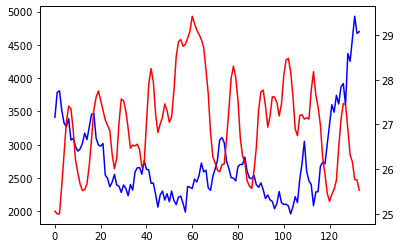

In [4]:
plt.figure()
df.종가.plot(style = 'b-')
df.nino34.plot(secondary_y = True, style = 'r')

## Cross-Correlation

In [5]:
def cross_corr(x, y, lag):
    return x.corr(y.shift(periods=lag))

In [6]:
cc = [cross_corr(df['nino34'], df['종가'], lag=i) for i in range(13)]
cc

[-0.5160620328289677,
 -0.4787420187571255,
 -0.42810203598664215,
 -0.37779219556015226,
 -0.3319495422811955,
 -0.3242463216328173,
 -0.3486498175278745,
 -0.4088786906448838,
 -0.47505933996253524,
 -0.5200528800247579,
 -0.537773756865121,
 -0.5052713174917699,
 -0.4387044949441734]

## 예측 데이터셋 생성
### 종속/독립 변수의 이전 값(t-n) 열 추가
snippet from: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
values = df[['종가', 'nino34']].values
data = series_to_supervised(values, n_in = 2)

In [5]:
df['nino-1'] = df['nino34'].shift(periods = 1)
df['nino-2'] = df['nino34'].shift(periods = 2)
df['종가-1'] = df['종가'].shift(periods = 1)
df['종가-2'] = df['종가'].shift(periods = 2)

In [6]:
data = df.drop(columns = ['nino34'])

In [7]:
data.dropna(inplace = True)

In [8]:
data.set_index('DATE', inplace = True)

In [11]:
data

,종가,nino-1,nino-2,종가-1,종가-2
DATE,,,,,
2011-01-01,3809.0,25.00,25.06,3788.0,3412.0
2011-02-01,3515.0,25.00,25.00,3809.0,3788.0
2011-03-01,3326.0,25.64,25.00,3515.0,3809.0
2011-04-01,3270.0,26.36,25.64,3326.0,3515.0
2011-05-01,3393.0,27.05,26.36,3270.0,3326.0
...,...,...,...,...,...
2021-08-01,4254.0,26.90,27.45,4369.0,3599.0
2021-09-01,4595.0,26.32,26.90,4254.0,4369.0
2021-10-01,4929.0,26.16,26.32,4595.0,4254.0


### 변수간 상관 확인
price vs price[-1]

Autocorrelation at lag = 1:	 0.9518766509128006


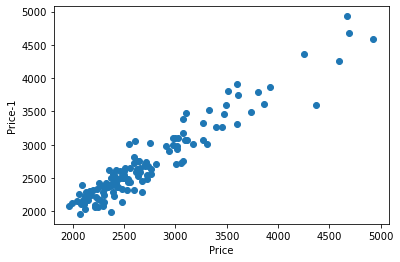

In [34]:
plt.scatter(data['종가'], data['종가-1'])
plt.xlabel('Price')
plt.ylabel('Price-1')

s = pd.Series(data['종가'])
print('Autocorrelation at lag = 1:\t', s.autocorr(lag=1))

nino[-1] vs nino[-2]

Autocorrelation at lag = 1:	 0.9165253657739503


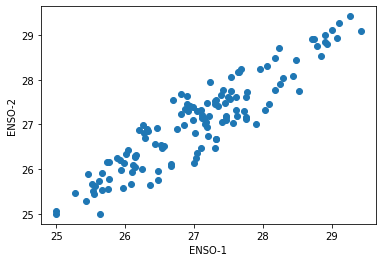

In [35]:
plt.scatter(data['nino-1'], data['nino-2'])
plt.xlabel('ENSO-1')
plt.ylabel('ENSO-2')

s = pd.Series(data['nino-1'])
print('Autocorrelation at lag = 1:\t', s.autocorr(lag=1))  

x = 엘니뇨-1

y = price 수익률(= price/price[-1] - 1)

In [36]:
X_del_nino = data['nino-1']
# Y_yield = (data['종가']/data['종가-1'])-1
Y_yield = data['종가'] - data['종가-1']

Text(0, 0.5, 'Yield')

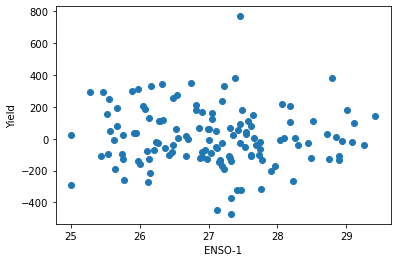

In [37]:
plt.scatter(X_del_nino, Y_yield)
plt.xlabel('ENSO-1')
plt.ylabel('Yield')

x = 엘니뇨변화(= nino[-1] - nino[-2])

y = price 수익률(= price/price[-1] - 1)

In [51]:
X_del_nino = data['nino-1'] - data['nino-2']
# Y_yield = (data['종가']/data['종가-1'])-1
Y_yield = data['종가'] - data['종가-1']

Text(0, 0.5, 'Yield')

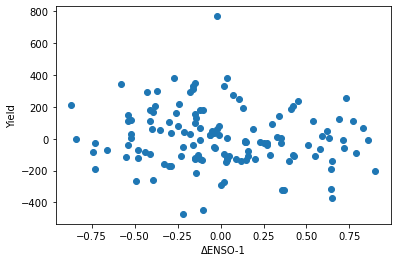

In [52]:
plt.scatter(X_del_nino, Y_yield)
plt.xlabel('\u0394ENSO-1')
plt.ylabel('Yield')

## Residual
x = 엘니뇨-1

y = residual price (seasonality 제거한 price)


code snippet from: https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

<ipython-input-50-437374e58f5f>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decompose_result = seasonal_decompose(data['종가'], model="additive", freq=12, extrapolate_trend=2)


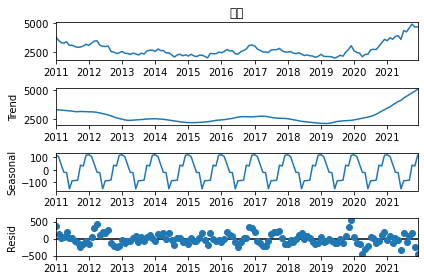

In [50]:
decompose_result = seasonal_decompose(data['종가'], model="additive", freq=12, extrapolate_trend=2)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

In [51]:
residual.tail(10)

DATE
2021-03-01   -134.204072
2021-04-01     27.653883
2021-05-01    -55.026042
2021-06-01   -348.910511
2021-07-01    160.492266
2021-08-01   -103.386521
2021-09-01     86.844539
2021-10-01    153.935448
2021-11-01   -244.200915
2021-12-01   -452.333491
Name: resid, dtype: float64

In [52]:
data['종가resd'] = residual

<AxesSubplot:xlabel='DATE'>

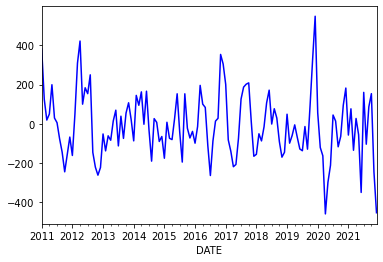

In [53]:
plt.figure()
data.종가resd.plot(style = 'b-')

In [14]:
X_del_nino = data['nino-1']
Y_yield = residual

Text(0, 0.5, 'Price Residual')

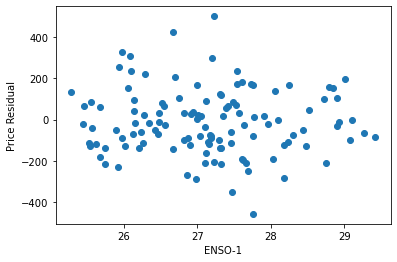

In [16]:
plt.scatter(X_del_nino, Y_yield)
plt.xlabel('ENSO-1')
plt.ylabel('Price Residual')

### train set 만들기
과적합 방지를 위하여 전체 중 60%만 학습에 사용한다. 모델마다 들어가는 독립변수가 다르므로 split 코드는 모델마다 새로 실행한다.

In [17]:
predict_var = '종가'

In [18]:
y = data[predict_var]

In [27]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

## Multiple Linear Regression
### ENSO-2, ENSO-1, Price-1

In [29]:
x = data.drop(columns = [predict_var, '종가-2'])

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
LR = LinearRegression()
LR.fit(x_train, y_train)

LinearRegression()

In [37]:
y_pred = LR.predict(x)

### 정확도

In [35]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [46]:
print('r2 score: ', r2_score(y, y_pred))
print('mean sqrt error: ', mean_squared_error(y, y_pred))
print('root mean sqrt error: ', np.sqrt(mean_squared_error(y, y_pred)))
print('R2: ', LR.score(x_train, y_train))

r2 score:  0.9094298100108278
mean sqrt error:  33035.55992908348
root mean sqrt error:  181.75687037656508
R2:  0.9261376125123769


### 가시화

Text(0, 0.5, 'Predicted Price')

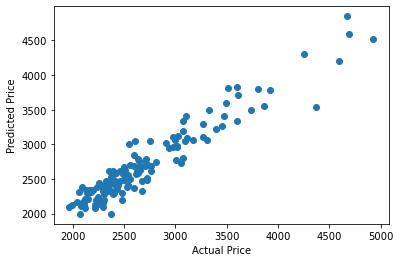

In [40]:
plt.scatter(y, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

### 중요성
code snippet from: https://hleecaster.com/ml-multiple-linear-regression-example/

In [41]:
LR.coef_

array([-62.66411051,  33.73545954,   0.93668832])

Text(0, 0.5, 'Price')

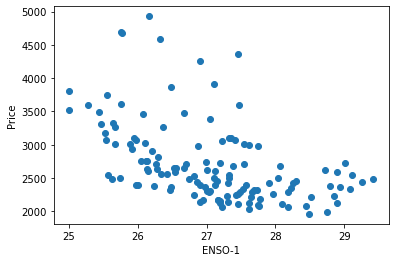

In [43]:
plt.scatter(x['nino-1'], y)
plt.xlabel('ENSO-1')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

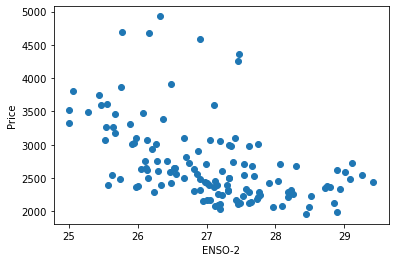

In [44]:
plt.scatter(x['nino-2'], y)
plt.xlabel('ENSO-2')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

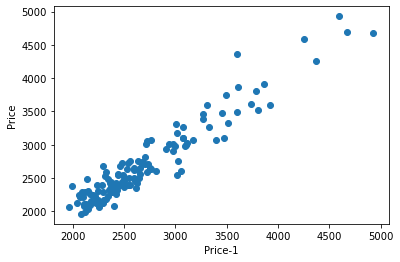

In [45]:
plt.scatter(x['종가-1'], y)
plt.xlabel('Price-1')
plt.ylabel('Price')

## Random Forest Regression 1
### ENSO-2, ENSO-1, Price-1
데이터셋이 충분히 크지 않아 x_train 대신 x를 이용하여 y를 예측한다.

In [ ]:
x = data.drop(columns = [predict_var])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)

RandomForestRegressor()

In [28]:
y_pred = regressor.predict(x)

### 정확도

In [29]:
errors = abs(y_pred - y)
print('Mean Absolute Error ', round(np.mean(errors), 2))

Mean Absolute Error  99.06


In [30]:
mape = 100 * (errors / y)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%')

Accuracy:  96.38 %


In [ ]:
r2_score(y_test, y_pred)

### 중요성
snippet from: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [32]:
feature_list = list(x.columns)
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 종가-1                 Importance: 0.87
Variable: 종가-2                 Importance: 0.08
Variable: nino-1               Importance: 0.02
Variable: nino-2               Importance: 0.02


### 가시화
snippet from: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [33]:
result_df = pd.concat([pd.DataFrame(y), pd.DataFrame(y_pred, index=y.index.copy())], axis = 1)

In [34]:
result_df.rename(columns = {0: 'predict'}, inplace = True)

In [35]:
result_df.head()

,종가,predict
DATE,,
2011-01-01,3809.0,3734.03
2011-02-01,3515.0,3628.30
2011-03-01,3326.0,3570.11
2011-04-01,3270.0,3560.40
2011-05-01,3393.0,3414.98


<AxesSubplot:label='1a273551-389a-4d68-b42f-b2b4c986c7db'>

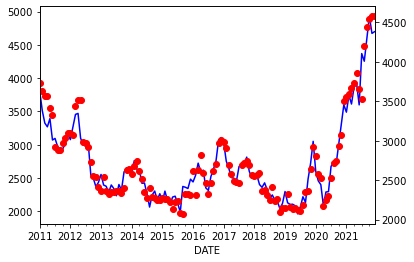

In [36]:
plt.figure()
result_df.종가.plot(style = 'b-')
result_df.predict.plot(secondary_y = True, style = 'ro')

## Random Forest Regression 2
### ENSO-2, ENSO-1

In [37]:
data = df.drop(columns = ['nino34', '평균가', '등락률(%)', '환산가($/ton)', '종가-1', '종가-2'])
data.dropna(inplace = True)

In [38]:
data.head()

,종가,nino-1,nino-2
DATE,,,
2011-01-01,3809.0,25.00,25.06
2011-02-01,3515.0,25.00,25.00
2011-03-01,3326.0,25.64,25.00
2011-04-01,3270.0,26.36,25.64
2011-05-01,3393.0,27.05,26.36


In [39]:
y = data[predict_var]
x = data.drop(columns = [predict_var])

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x)

In [41]:
errors = abs(y_pred - y)
print('Mean Absolute Error ', round(np.mean(errors), 2))

mape = 100 * (errors / y)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%')

# r2_score(y_test, y_pred)

Mean Absolute Error  276.38
Accuracy:  89.92 %


In [42]:
feature_list = list(x.columns)
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: nino-1               Importance: 0.55
Variable: nino-2               Importance: 0.45


In [43]:
regressor.score(x, y)

0.47123267204015407

In [44]:
result_df = pd.concat([pd.DataFrame(y), pd.DataFrame(y_pred, index=y.index.copy())], axis = 1)

In [45]:
result_df.rename(columns = {0: 'predict'}, inplace = True)

<AxesSubplot:label='919eeb99-48b0-4356-976a-32dfabd372f5'>

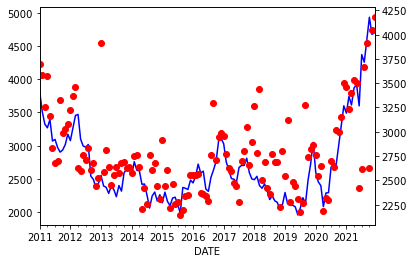

In [46]:
plt.figure()
result_df.종가.plot(style = 'b-')
result_df.predict.plot(secondary_y = True, style = 'ro')

## Random Forest Regression with TimeSeriesSplit
code snippet from: https://www.kaggle.com/tomwarrens/timeseriessplit-how-to-use-it

and https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [54]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [55]:
tscv = TimeSeriesSplit(n_splits=8)

In [56]:
X = data['nino-1']
y = data['종가resd']

In [57]:
from sklearn.ensemble import RandomForestRegressor

-3.8009426464869973
-0.6410568322613757
-1.220104590438456
-1.1419685368288652
-0.41361633659994257
-1.6971767701838605
-0.319348060441647
0.13799825350438744


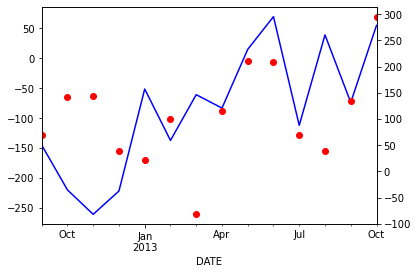

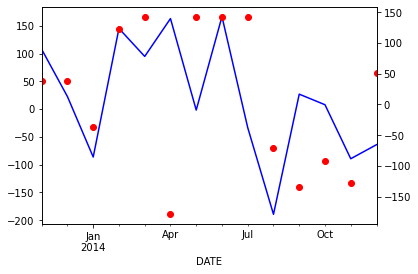

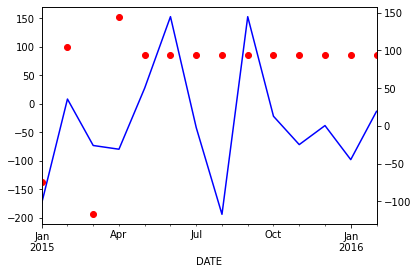

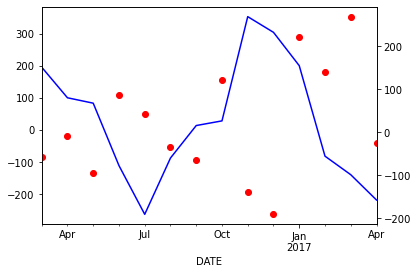

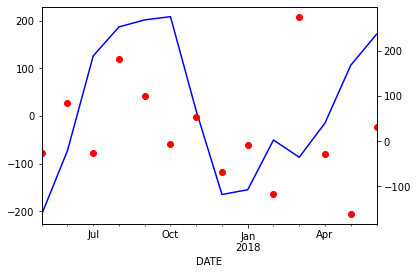

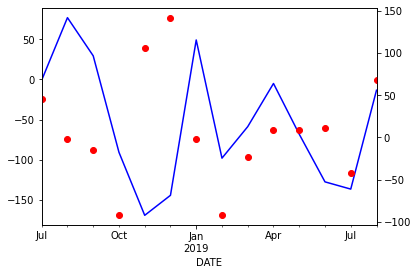

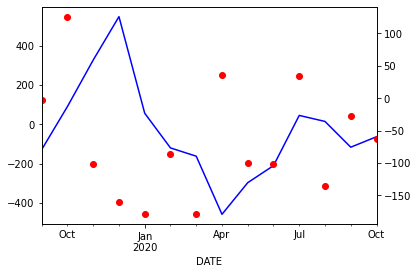

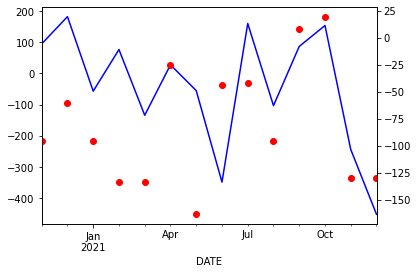

In [59]:
for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    regressor = RandomForestRegressor()
    regressor.fit(np.array(X_train.tolist()).reshape(-1, 1), y_train)
    
    y_pred = regressor.predict(np.array(X_test.tolist()).reshape(-1, 1))
    
    print(regressor.score(np.array(X_test.tolist()).reshape(-1, 1), y_test))
#     print('r2 score: ', r2_score(y_test, y_pred))
    
    result_df = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred, index=y_test.index.copy())], axis = 1)
    result_df.rename(columns = {0: 'predict'}, inplace = True)
    
    plt.figure()
    result_df.종가resd.plot(style = 'b-')
    result_df.predict.plot(secondary_y = True, style = 'ro')